In [1]:
import jax
jax.config.update('jax_enable_x64',True)
jax.config.update("jax_default_device",jax.devices()[1])
import jax.numpy as jnp
import diffrax

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from jax.random import key

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel,PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings,AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier,NoSparsifier
from pysindy import STLSQ,SR3,MIOSR
import jsindy
from numpy import loadtxt
from pysindy import EnsembleOptimizer

In [2]:
t1 = 10
x0 = jnp.array([2,0.])
def f(t,x,args):
    return jnp.array([- 0.1*x[0]**3 + 2*x[1]**3,- 0.1*x[1]**3 -2*x[0]**3])
ode = diffrax.ODETerm(f)
step_control = diffrax.PIDController(rtol = 1e-7,atol =1e-7)
solver = diffrax.Tsit5()
save_at = diffrax.SaveAt(dense = True)

sol = diffrax.diffeqsolve(ode,solver,0.,20.,dt0 = 0.005,y0 = x0,saveat = save_at,stepsize_controller=step_control)

dt_train = 0.05

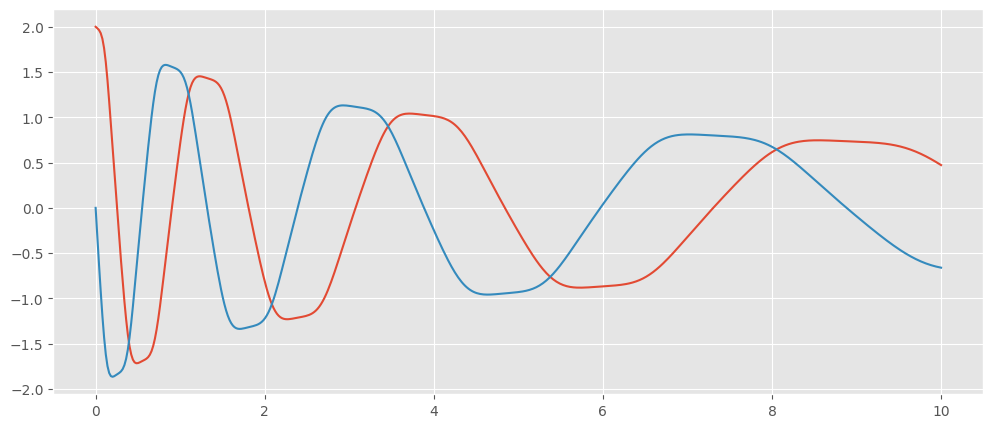

In [3]:
t_fine = jnp.linspace(0,t1,500)
x_vals = jax.vmap(sol.evaluate)(t_fine)

plt.figure(figsize=(12,5))
plt.plot(t_fine,x_vals[:,0])
plt.plot(t_fine,x_vals[:,1])

In [24]:
trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.,feature_map=PolyLib(3))
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  10.
colloc_weight = 1e5
# sparsifier = pySindySparsifier(
#     EnsembleOptimizer(
#         STLSQ(threshold = 0.1,alpha = 10.),
#         bagging=True,
#         n_models = 200)
#     )
sparsifier = pySindySparsifier(STLSQ(threshold = 0.08,alpha = 100.))

# sparsifier = NoSparsifier()

optimizer = AlternatingActiveSetLMSolver(
        beta_reg=1e-5,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x','y']
)




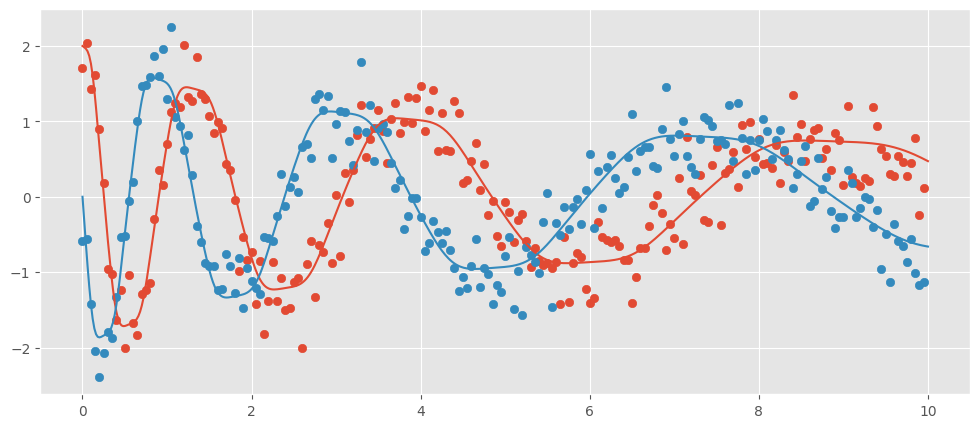

{'show_progress': True, 'sigma2_est': Array(0.10040444, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Warm Start


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration 0, loss = 5.072e+04, gradnorm = 1.195e+06, alpha = 4.167, improvement_ratio = 0.8979
Iteration 1, loss = 3.698e+03, gradnorm = 3.344e+05, alpha = 3.472, improvement_ratio = 0.9308
Iteration 2, loss = 346.3, gradnorm = 1.15e+05, alpha = 2.894, improvement_ratio = 0.959
Iteration 3, loss = 208.3, gradnorm = 2.891e+04, alpha = 2.411, improvement_ratio = 0.9511
Iteration 4, loss = 200.9, gradnorm = 7.095e+03, alpha = 2.009, improvement_ratio = 0.8895
Iteration 5, loss = 199.4, gradnorm = 2.524e+03, alpha = 1.674, improvement_ratio = 0.8205
Iteration 100, loss = 190.0, gradnorm = 0.0001808, alpha = 83.33, improvement_ratio = 2.982e+04
Iteration 106, loss = 190.0, gradnorm = 0.0003119, alpha = 94.19, improvement_ratio = inf
Model after smooth warm start
(x)' = 0.119 1 + -0.208 x + 0.126 y + -0.179 x^2 + -0.228 x y + 0.101 y^2 + -0.072 x^2 y + -0.088 x y^2 + 1.815 y^3
(y)' = -0.066 1 + -0.103 x + 0.233 y + -0.269 x^2 + 0.154 x y + 0.161 y^2 + -1.869 x^3 + -0.145 x^2 y + -0.190 x y^2

In [25]:
t_train = jnp.arange(0,t1,dt_train)
x_train_true = jax.vmap(sol.evaluate)(t_train)

noise_sigma = 0.32
x_train = x_train_true + noise_sigma * jax.random.normal(key(111),(x_train_true.shape))

plt.figure(figsize=(12,5))
plt.scatter(t_train,x_train[:,0])
plt.scatter(t_train,x_train[:,1])
plt.plot(t_fine,x_vals[:,0])
plt.plot(t_fine,x_vals[:,1])
plt.show()

model.fit(t_train,x_train)


In [26]:
model.print()

(x)' = 0.078 y + -0.560 x y^2 + 1.859 y^3
(y)' = -0.008 x + -0.212 x^2 + -1.950 x^3 + -0.284 x y^2


In [27]:
def f_pred(t,x,args):
    return model.predict(x)

def simulate_sol(y0,system, t0,t1,t_eval,dt0=1e-3, args = None):
    term = diffrax.ODETerm(system)
    stepsize_controller = diffrax.PIDController(rtol = 1e-8,atol = 1e-8)
    solver = diffrax.Tsit5()

    save_at = diffrax.SaveAt(dense=True)
    sol = diffrax.diffeqsolve(
        term,
        solver,
        t0 = t0,
        t1=t1,
        dt0=dt0,
        y0=y0,
        args = args,
        saveat=save_at,
        max_steps=int(10*(t1-t0)/dt0),
        stepsize_controller=stepsize_controller
    )
    return jax.vmap(sol.evaluate)(t_eval)


t_extend = jnp.linspace(9.95,2*t1,1000)
x0_new = sol.evaluate(t_extend[0])
x_true_extend = simulate_sol(x0_new,t0 = t_extend[0],t1 = t_extend[-1],system=f,t_eval = t_extend)

fitted_system = jax.jit(lambda t,x,args:model.predict(x))
x_sim_extend = simulate_sol(x0_new,t0 = t_extend[0],t1 = t_extend[-1],system=fitted_system,t_eval = t_extend)

x_pred = model.predict_state(t_fine)

x_fine = jax.vmap(sol.evaluate)(t_fine)

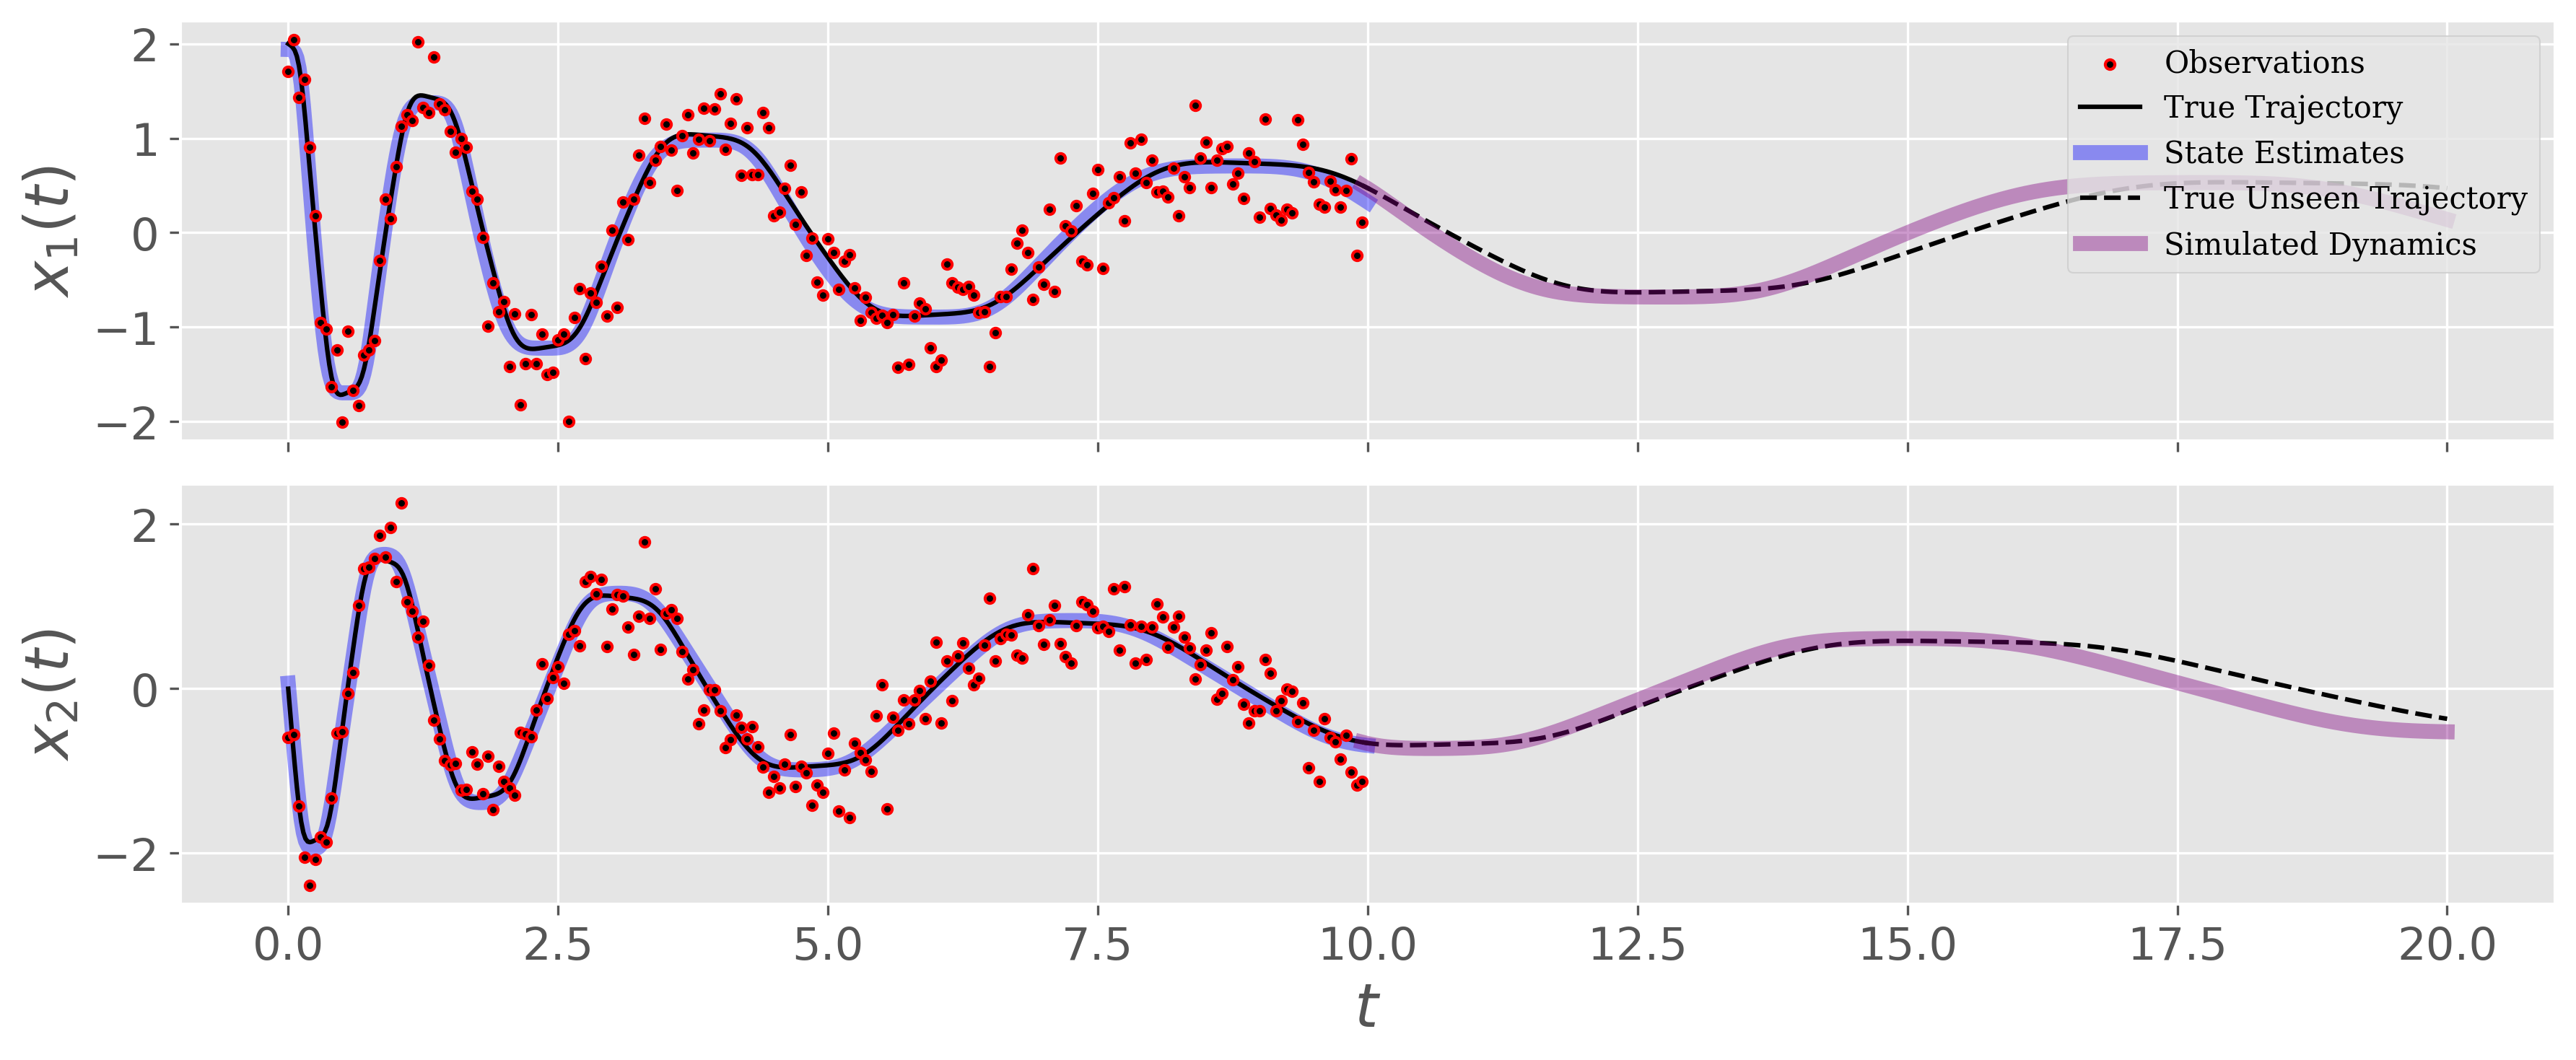

In [28]:
family='serif'
fig, ax = plt.subplots(2,1, figsize=(12,5),sharex=True,dpi=300)
ylabels = [r"$x_1(t)$", r"$x_2(t)$"]
for idx in range(2):
    ax[idx].scatter(t_train, x_train[:,idx],facecolors='black',edgecolors='red',lw=1, label='Observations',s=10,zorder=3)
    
    ax[idx].plot(t_fine, x_fine[:,idx], label='True Trajectory',c='black',zorder=2)
    ax[idx].plot(t_fine, x_pred[:,idx], label='State Estimates', linestyle='-',c='blue', alpha=0.4,lw=5,zorder=1)

    ax[idx].plot(t_extend,x_true_extend[:,idx], c='black', linestyle='--', label='True Unseen Trajectory')    

    ax[idx].plot(t_extend,x_sim_extend[:,idx],c='purple',alpha=0.4, lw=5,linestyle='-',label='Simulated Dynamics')

    ax[idx].grid(True)
    if idx == 1:
        ax[idx].set_ylabel(ylabels[idx], size=20, family=family)
    else:
        ax[idx].set_ylabel(ylabels[idx], size=20, family=family,)
    if idx==0:
        # after the plotting loop, or inside the idx == 1 block:
        ax[0].set_yticks([-2,-1,0,1,2])

        ax[idx].legend(prop={'family':family},loc='upper right')
    if idx == 1:
        ax[idx].set_xlabel(r"$t$",size=20, family=family)

ax[0].tick_params(axis='both', labelsize=15)
ax[1].tick_params(axis='both', labelsize=15)

plt.tight_layout()
# if savefigs:
plt.savefig(f"extra-osc.pdf")
plt.show()

In [29]:
true_theta = jnp.array(
    [[ 0.        ,  0.        ],
    [ 0.        , 0.    ],
    [0. ,  0.        ],
    [ 0.        ,  0.        ],
    [ 0.        ,  0.        ],
    [ 0.        ,  0.        ],
    [-0.1, -2.],
    [ 0.        ,  0.        ],
    [ 0.        ,  0.        ],
    [ 2., -0.1]])

In [30]:
rmse_x = jnp.sqrt(jnp.mean(jnp.mean((x_fine - x_pred)**2,axis=0)/jnp.var(x_fine,axis=0)))
rmse_theta = jnp.linalg.norm(true_theta - model.theta) / jnp.linalg.norm(true_theta)


In [31]:
rmse_theta

Array(0.24661059, dtype=float64)

In [32]:
rmse_x

Array(0.06593583, dtype=float64)

In [33]:
0.32/jnp.std(x_fine)

Array(0.38223923, dtype=float64)